In [9]:
%load_ext autoreload
%autoreload 1
%aimport modules.dataset_auxiliary, modules.classification_auxiliary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import tensorly as tl
from tensorly import random
import os
import pickle
import modules.dataset_auxiliary as daux
from modules.dataset_auxiliary import *
from modules.classification_auxiliary import *
import copy


In [11]:
ls

backup/  env/  modules/  requirements.txt  tensors.ipynb  tensors_my.ipynb


## Load initial ds_dict

In [12]:
# current version
file_path = r'backup/ds_dict.pkl'

# # save:
# with open(file_path, 'wb') as f:
#     pickle.dump(ds_dict, f)

# load:
with open(file_path, 'rb') as f:
    ds_dict = pickle.load(f)

check_ds_dict(ds_dict)
print()

True 	Info: 7468;   Skeleton: 7468;   Total: 7468



In [5]:
ds_dict['G101__trial1__both__moving_right'][INFO_KEY]['label']

{'is_valid_performance': True, 'action_start': 27.5, 'action_end': 78.5}

In [16]:
df = ds_dict['G101__trial1__both__moving_right'][SKELETON_KEY]

## Selecting 

In [18]:
gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']
gestures = ['scroll_up', 'scroll_down', 'swipe_right', 'swipe_left', 'export'] 
# gestures = ['screenshot', 'writing', 'delete']
# gestyres = ['moving_down', 'moving_left', 'moving_right', 'moving_up', 'moving_back', 'moving_forward']
# gestures = ['anticlockwise', 'clockwise', 'right_forward', 'left_forward']
# gesture = ['zoom_in_c', 'zoom_out_c', 'zoom_out_l', 'zoom_out_r', 'zoom_in_l',  'zoom_in_r']
# gesture = ['yes_head', 'no_head']

In [275]:
exp_cofig = "one hand gestures  | [x, y] | fill_na: {'value':0} | train: subs[0:16], test: subs[16:]"

Selected  2812 samples. 4656(7468) was dropped!
14 samples was unvalied. Ramain 2798(2812)


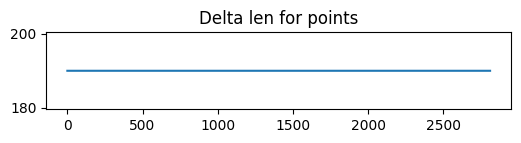

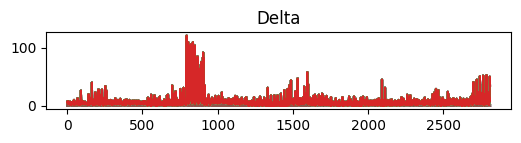

Train
Selected  2141 samples. 671(2812) was dropped!
Test
Selected  671 samples. 2141(2812) was dropped!


In [239]:
# preparing

subs = get_all_subs_from_ds_dict(ds_dict)
subs = subs[:]
gestures = ['start', 'call', 'mute', 'pupil', 'high', 'select', 'unmute', 'close', 'yes', 'no', 'save']


data_dict_selected = select_g_ids(ds_dict, subs=subs, gestures=gestures)
data_dict_valid =  select_valid_samplels(data_dict_selected)

# points
data_dict_points = select_points(data_dict_selected, coords=['x', 'y'])
plt.show()

# nan
data_dict_filled = update_skeleton(data_dict_points, update_df_fill_na, {'value':0})
plt.show()

data_dict_adjusted = update_skeleton(data_dict_filled, update_df_solve_time, show=False)


#train
print('Train')
data_dict = select_g_ids(data_dict_adjusted, subs=subs[0:16])
data_dict, label_dict = form_gesture_labels(data_dict)
samples_list,  labels_list = form_samples_labels_lists(data_dict)
tensor = np.concatenate(samples_list, axis=0)

#test 
print('Test')
data_dict_test = select_g_ids(data_dict_adjusted, subs=subs[16:])
data_dict_test, label_dict_test = form_gesture_labels(data_dict_test)
samples_list_test,  labels_list_test = form_samples_labels_lists(data_dict_test)
tensor_test = np.concatenate(samples_list_test, axis=0)



In [243]:
tensor.shape

(2141, 120, 134)

In [246]:
# hand_points = [i for i in range(21)]
# coords='xy'


# df.columns[df.columns.str.match(f"^(right|left)_hand__({hand_points})__[{coords}]")]

In [247]:
import tensorly as tl
from tensorly import random
from tensorly.decomposition import tucker, parafac
from tensorly.tenalg import mode_dot, multi_mode_dot


### CPD

In [249]:
# CPD
t = tensor
tt = tensor_test
rank = 8
factors_CPD = parafac(t, rank=rank)


In [336]:
t_rec_CPD = tl.cp_to_tensor(factors_CPD)
print(f"CPD: Rank: {rank: }, distance: {tl.norm(t - t_rec_CPD)} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_CPD)}")

ValueError: too many values to unpack (expected 2)

In [308]:

factors = factors_CPD
# core = gen_diag_core_tensor(rank,len(factors.factors), factors.weights)
# classes = mode_dot(core_t, factors.factors[0], mode=0)

classes_CPD = multi_mode_dot(t, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])
classes_CPD_test = multi_mode_dot(tt, [matrix.T for matrix in factors.factors[1:]], modes=[1, 2])

### Tucker

In [363]:
# Tucker with HOSVD
t = tensor
tt = tensor_test
ranks = [8, 8, 8]
core_tucker, factors_tucker = tucker(t, rank=rank)


/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/tensorly/tucker_tensor.py:380: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


In [364]:
t_rec_tucker = tl.tucker_to_tensor((core_tucker, factors_tucker))
print(f"Tucker: Rank: {rank: }, distance: {tl.norm(t - t_rec_tucker)} ; norm origin: {tl.norm(t)} ; norm recovered: {tl.norm(t_rec_tucker)}")

Tucker: Rank:  8, distance: 420.42386295330414 ; norm origin: 3705.267245227629 ; norm recovered: 3681.337954333478


In [372]:
factors = factors_tucker
# core = core_tucker
# classes_tucker = mode_dot(core, factors[0], mode=0)

classes_tucker = multi_mode_dot(t, [matrix.T for matrix in factors[1:]], modes=[1, 2])
classes_tucker_test = multi_mode_dot(tt, [matrix.T for matrix in factors[1:]], modes=[1, 2])

## ML part 

In [213]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

In [350]:

def make_X_y(tensor, labels_list):
    X = tensor.reshape(tensor.shape[0], -1)
    y = np.array(labels_list)
    return X, y

def plot_confusion_matrix(y_test, label, label_dict, ax=None):
    # print(classification_report(label, y_test,
    #                             target_names=[l for l in label_dict.values()]))

    conf_mat = confusion_matrix(label, y_test)

    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_axes([0, 0, 0.8,  0.8])
    else:
        fig = ax.get_figure()

    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = ax.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                ax.text(j-.2, i+.1, c, fontsize=8)
                
    # cb = fig.colorbar(res)
    cb = plt.colorbar(res, ax=ax)
    ax.set_title('Confusion Matrix')
    _ = ax.set_xticks(range(22), [l for l in label_dict.values()], rotation=90)
    _ = ax.set_yticks(range(22), [l for l in label_dict.values()])
    
def print_classification_report(y_test, label, label_dict):
    print(classification_report(label, y_test,
                                target_names=[l for l in label_dict.values()]))
    
    
def compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict, fig_size=[14, 6]):
    fig, (ax_train, ax_test) = plt.subplots(1, 2)
    fig.set_size_inches(fig_size)
    
    plot_confusion_matrix(y_train, label_train, label_dict, ax=ax_train)
    acc_train = accuracy_score(y_train, label_train)
    ax_train.set_title(f"Train: {acc_train :0.4}")
    
    plot_confusion_matrix(y_test, label_test, label_dict, ax=ax_test)
    acc_test = accuracy_score(y_test, label_test)
    ax_test.set_title(f"Test: {acc_test :0.4}")
    
    
def check_KNN(X_train, y_train, X_test, y_test, model_name,  n_start=1, n_end=20):
    acc_train_list = []
    acc_test_list = []
    for n_neighbors in range(n_start, n_end):
        print(f'n_neighbors = {n_neighbors} from {n_end}')
        model = KNeighborsClassifier(n_neighbors=n_neighbors)

        model.fit(X_train, y_train)
        label_train = model.predict(X_train)
        acc_train = accuracy_score(y_train, label_train)
        acc_train_list += [acc_train]
        label_test = model.predict(X_test)
        acc_test = accuracy_score(y_test, label_test)
        acc_test_list += [acc_test]
        clear_output()
        
        
    plt.plot(range(n_start, n_end), acc_train_list, label='train')
    plt.plot(range(n_start, n_end), acc_test_list, label='test')
    plt.legend()
    plt.title(model_name)
    plt.gca().set_xlabel('N neighbors')
    plt.gca().set_ylabel('Mean accuracy')
    
    
    
    
    

### Origin

#### LogReg

In [262]:
model = LogisticRegression(max_iter=200)
model_name = 'LogReg'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

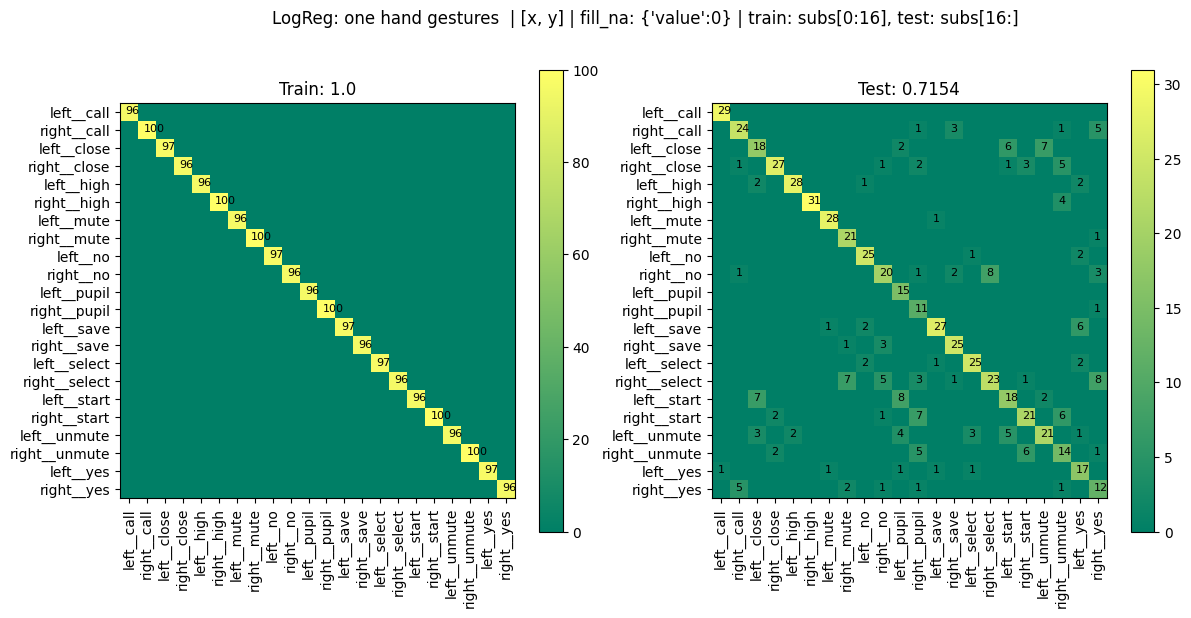

In [264]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()


In [181]:
# label = model.predict(X_test)
# acc = accuracy_score(y_test, label )
# print(acc)
# plot_confusion_matrix(y_test, label, label_dict)
# plt.title('Confusion Matrix: Test data')

#### KNN

In [304]:
model = KNeighborsClassifier(n_neighbors=8)
model_name = 'KNN'
X_train, y_train = make_X_y(tensor, labels_list)
X_test, y_test = make_X_y(tensor_test, labels_list_test)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

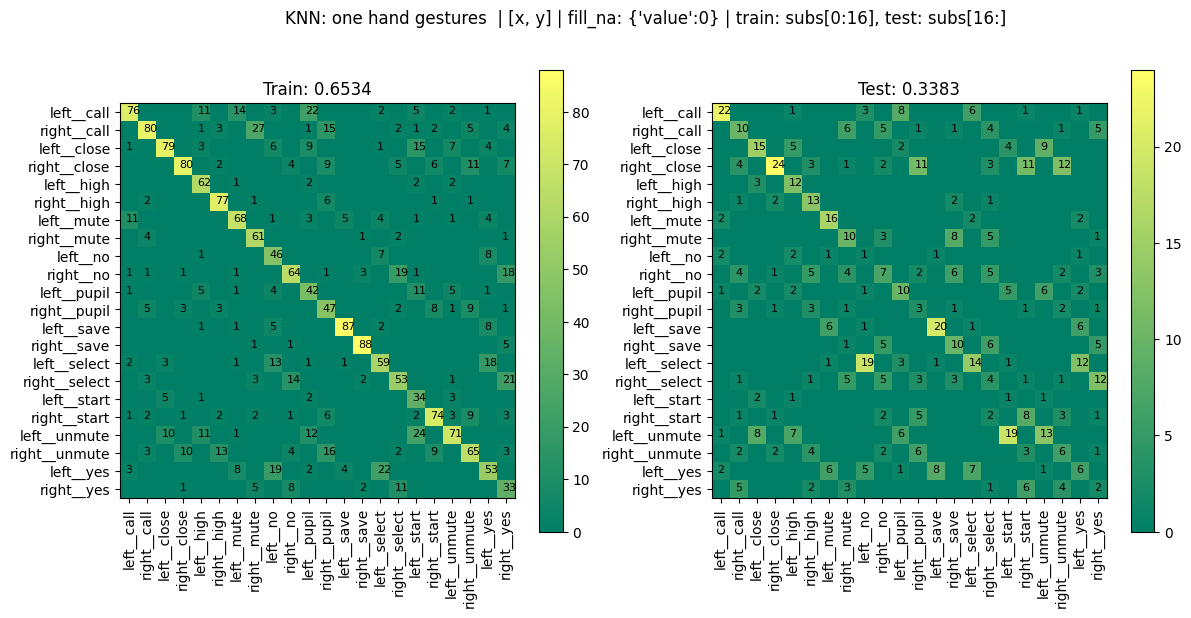

In [305]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

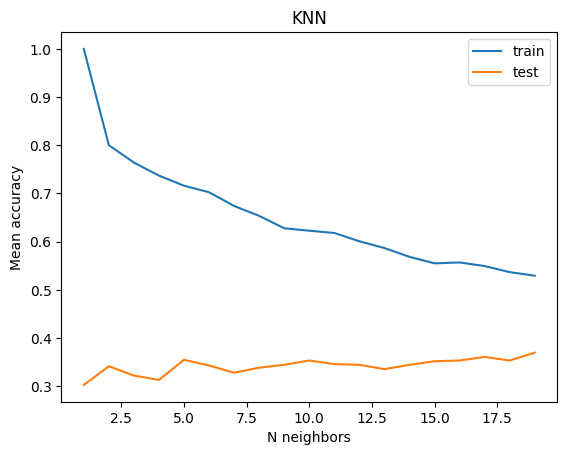

In [306]:
check_KNN(X_train, y_train, X_test, y_test, model_name)

### After CPD

In [ ]:
classes = classes_CPD
classes_test = classes_CPD_test

#### LogReg

In [271]:
model = LogisticRegression(max_iter=1000)
model_name = 'CPD + LogReg'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

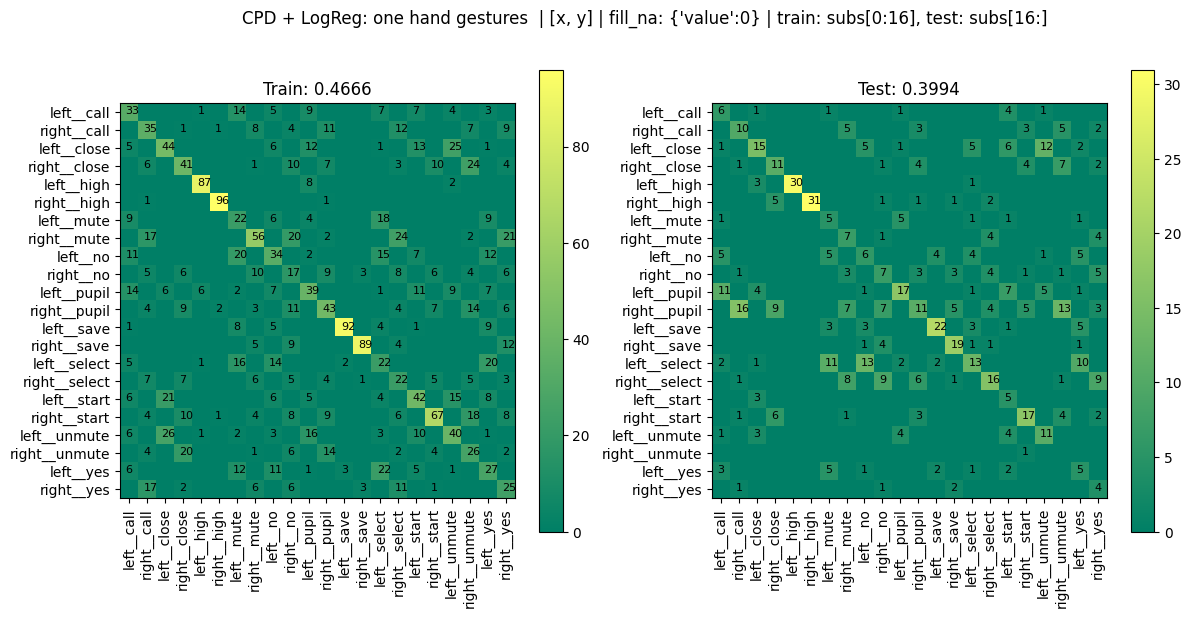

In [272]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### KNN

In [302]:
model = KNeighborsClassifier(n_neighbors=14)
model_name = 'CPD + KNN'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=14)

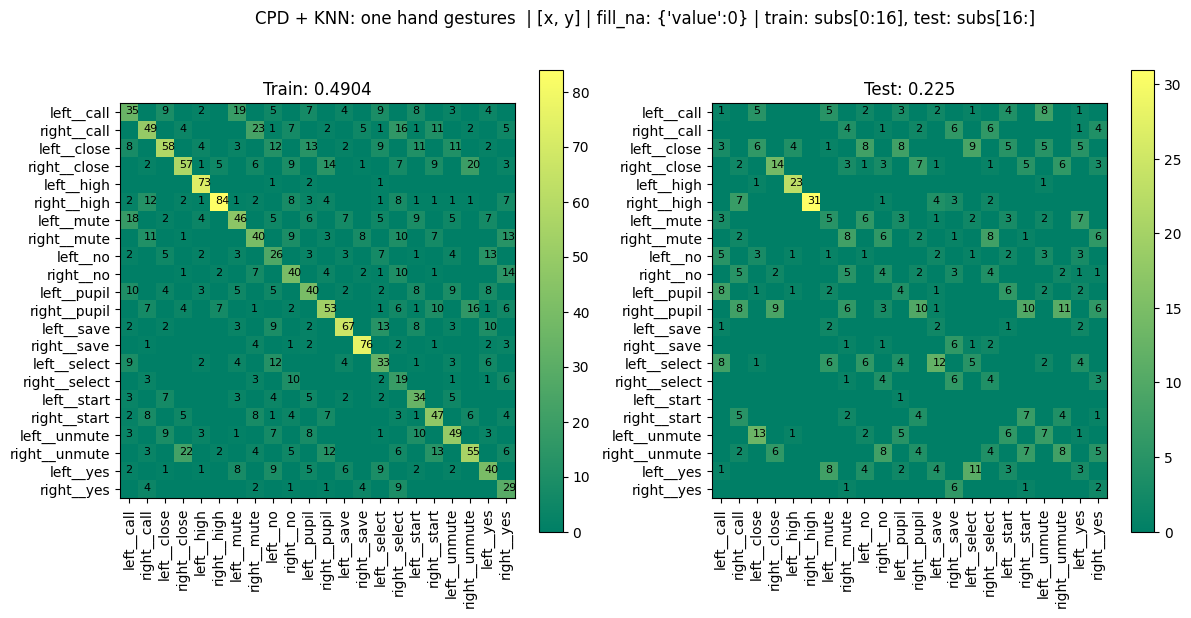

In [303]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

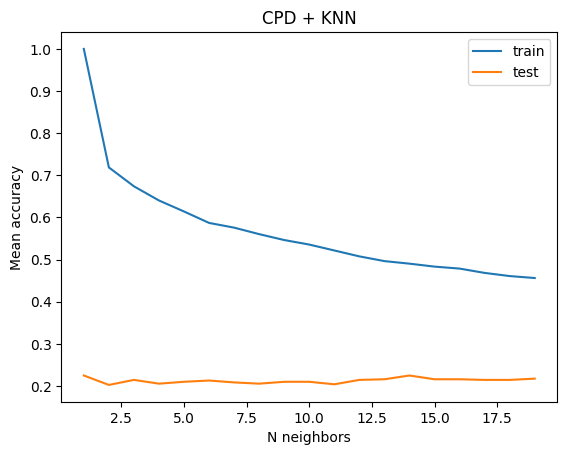

In [296]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  

### After Tucker

In [375]:
classes = classes_tucker
classes_test = classes_tucker_test

#### LogReg

In [376]:
model = LogisticRegression(max_iter=1000)
model_name = 'Tucker + LogReg'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

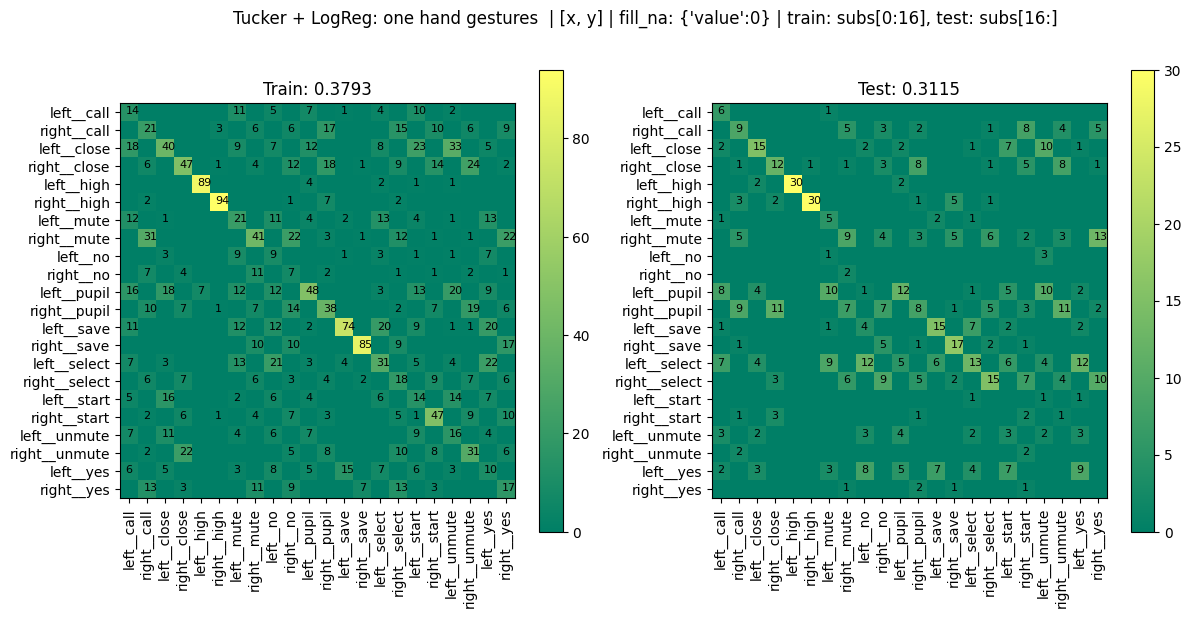

In [377]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

#### KNN

In [385]:
model = KNeighborsClassifier(n_neighbors=30)
model_name = 'Tucker+ KNN'
X_train, y_train = make_X_y(classes, labels_list)
X_test, y_test = make_X_y(classes_test, labels_list_test)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

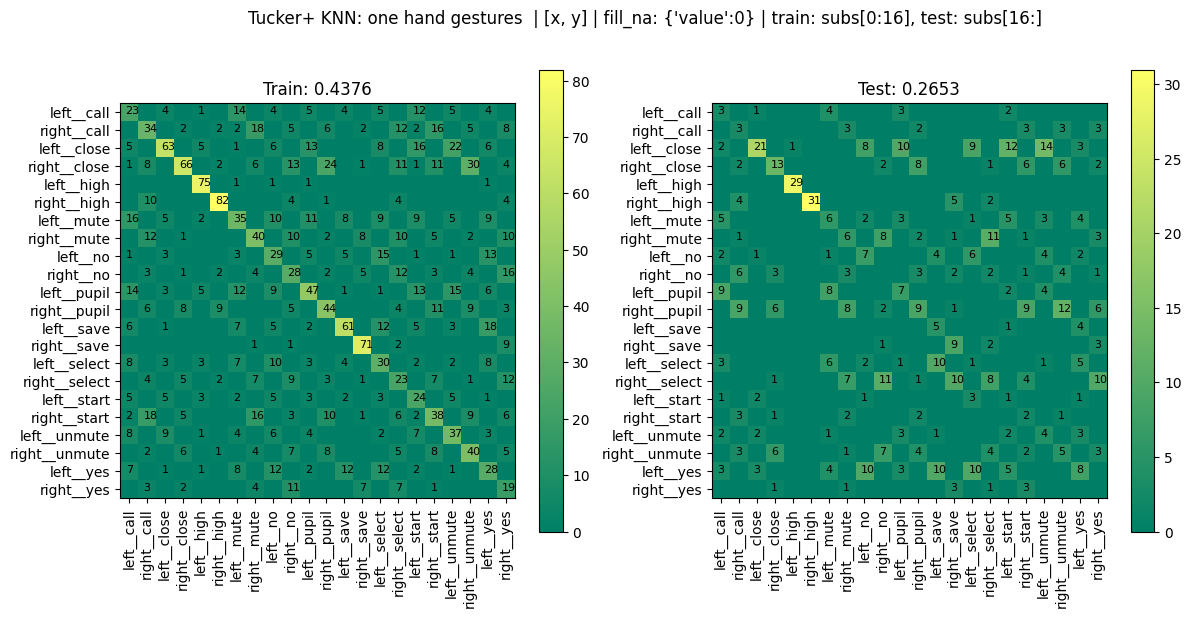

In [386]:
label_train = model.predict(X_train)
label_test = model.predict(X_test)
clear_output()
compare_train_test_confusion_matrices(y_train, label_train, y_test, label_test, label_dict)
plt.gcf().suptitle( model_name+ ": "+ exp_cofig)
print()

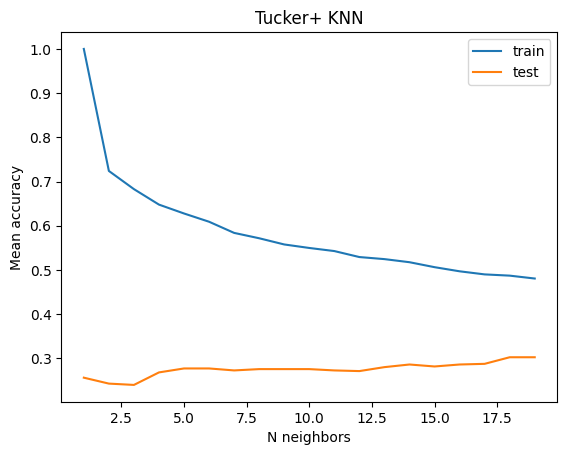

In [380]:
check_KNN(X_train, y_train, X_test, y_test, model_name)  